In [37]:
import numpy as np
import pandas as pd

Following Ruibo's approach, we perform cleannng for both the categorical and the numerical variables. For the categorical variables, we turn entries in the null list and N/A into missing. For the numerical variables, we turn N/A into -1. 

In [38]:
df_train = pd.read_csv("../data/train_set.csv")

df_train_cleaned = df_train.copy(deep=True)

# cleaning categorical variables

cat_columns = df_train_cleaned.select_dtypes(include = ['O']).columns

null_list = ["Not done", "Not tested", "Other", "Missing disease status", "Non-resident of the U.S."]
df_train_cleaned.loc[:,cat_columns] = df_train_cleaned[cat_columns].replace(null_list, "missing")

df_train_cleaned.loc[:,cat_columns] = df_train_cleaned[cat_columns].fillna('missing')

# cleaning numerical variables

num_columns = df_train.select_dtypes(include = ['float64']).columns

df_train_cleaned.loc[:, num_columns] = df_train_cleaned[num_columns].fillna(-1.0)

Based on Ray and Ela's heuristics and Yang's observation from the feature selection notebook, we select some features to fit the Weibull AFT model. In general, AFT models the survival time $T$ as
$$
\log{T} = \sum_{i=1}^n \beta_i X_i + \epsilon,
$$
where $X_i$'s are the covariates and $\epsilon$ is distributed as $\log{T_0}$ (the logarithm of a base survival time). There are several common choices for the distribution of $\log{T_0}$ such as log-logistic, log-normal or Weibull. When Weibull distribution is used, the cumulative hazard function is
$$
H(t;x) = \int_0^th(s;x)\,ds = \left( \frac{t}{\lambda(x)}\right)^{\rho},
$$
where $\lambda(x) = \exp(b_0 + \sum_{i=1}^n b_ix_i)$. The interpretation for $b_i$ is that a unit increase in $x_i$ will change the mean survival time by a factor of $\exp(b_i)$. Note that Weibull AFT model can be regarded as proportional hazards model, and it is the only family of distribution with such property. 

In [39]:
## Here, we use the selected hla features to fit the Weibull AFT model from lifelines.  

from lifelines import WeibullAFTFitter

features = ["hla_high_res_8", "hla_low_res_8", "hla_match_drb1_high", "hla_match_drb1_low", "efs_time", "efs"]

aft = WeibullAFTFitter()

aft.fit(df_train_cleaned[features], duration_col='efs_time', event_col='efs')

aft.print_summary(3)  # access the results using aft.summary

<lifelines.WeibullAFTFitter: fitted with 23040 total observations, 10612 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
   number of observations = 23040
number of events observed = 12428
           log-likelihood = -56942.737
         time fit was run = 2025-03-26 22:01:29 UTC

---
                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                             
lambda_ hla_high_res_8       0.019     1.019     0.007           0.006           0.032               1.006               1.032
        hla_low_res_8        0.033     1.033     0.009           0.014           0.051               1.014               1.052
        hla_match_drb1_high -0.128     0.880     0.024          -0.175          -0.082               0.839               0.922
        hla_match_drb1_low  -0.122     0.885     0.029          -0.179          -0.065               0.836               0.937
        Intercept            3.997    54.430     0.032           3.934           4.060              51.114              57.960
rho_    Intercept           -0.450     0.637     0.008          -0.465          -0.436               0.628               0.647

                             cmp to       z       p  -log2(p)
param   covariate                                            
lambda_ hla_high_res_8        0.000   2.860   0.004     7.885
        hla_low_res_8         0.000   3.450   0.001    10.802
        hla_match_drb1_high   0.000  -5.389 <0.0005    23.753
        hla_match_drb1_low    0.000  -4.197 <0.0005    15.172
        Intercept             0.000 124.657 <0.0005       inf
rho_    Intercept             0.000 -59.478 <0.0005       inf
---
Concordance = 0.527
AIC = 113897.475
log-likelihood ratio test = 64.496 on 4 df
-log2(p) of ll-ratio test = 41.469

In the following, we demonstrate fitting an AFT model with scikit-survival; an introdcution to the package and comparision with other survival analysis toolboxes can be found in: https://www.jmlr.org/papers/volume21/20-729/20-729.pdf. 

The package is designed similarly as in the mehtods in sklearn. The main difference is that for the right hand side $y$ we have a list of tuples (structured array); the first entry of the tuple indicates whether the data is censored, and the second entry indicates the survival time. One can use a helper class to create the structured array from dataframe.

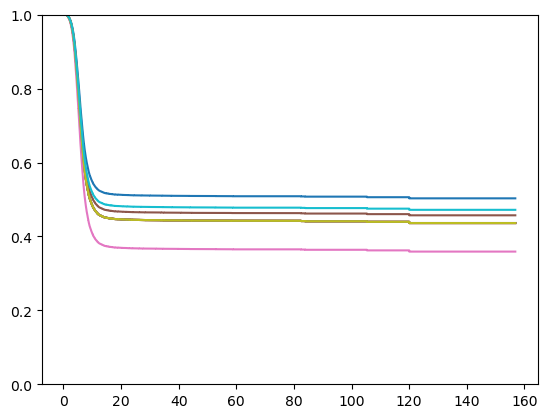

In [40]:
## Here, we use the selected hla features to fit the Cox proportional hazards model 

from sksurv.util import Surv
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from matplotlib import pyplot as plt

# prepare the data for training

features = ["hla_high_res_8", "hla_low_res_8", "hla_match_drb1_high", "hla_match_drb1_low"]

X = df_train_cleaned[features]

surv = Surv() #a helper class to construct the structured array for sksurv

y = surv.from_dataframe("efs", "efs_time", df_train_cleaned)

# fit the model

estimator = GradientBoostingSurvivalAnalysis(loss="coxph").fit(X, y)

# plot a sample of predicted survival functions

surv_funcs = estimator.predict_survival_function(X.iloc[:10])

for fn in surv_funcs:
    plt.step(fn.x, fn(fn.x), where="post")

plt.ylim(0, 1)
plt.show()


Finally, we presenet some discussion on how to define a risk score. Following the notations in https://en.wikipedia.org/wiki/Accelerated_failure_time_model, let $\theta_1 = \exp(-(\sum_{i=1}^p \beta_i X_{1, \,i}))$ and $\theta_2 = \exp(-(\sum_{i=1}^p \beta_i X_{2, \,i}))$ be the scaling constants obtained for two different people. One has
$$
S(t\vert \theta_i) = S_0(\theta_i t), \quad i=1, 2.
$$
A direct calculation shows that 
$$
\mathbb{E}T_i = \frac{1}{\theta_i^2}\mathbb{E}T_0, \quad i=1, 2,
$$
and this suggests that under AFT it is reasonable to use $\theta = \exp(-(\sum_{i=1}^p \beta_i X_i))$ as the risk score. 